In [53]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np
from pandas.io.json import json_normalize
import requests                  # [handles the http interactions](http://docs.python-requests.org/en/master/) 
from bs4 import BeautifulSoup    # beautiful soup handles the html to text conversion and more
import re                        # regular expressions are necessary for finding the crumb (more on crumbs later)
from datetime import datetime    # string to datetime object conversion
from time import mktime          # mktime transforms datetime objects to unix timestamps

In [54]:
#variables

tickers = ['AAPL', 'MSFT', 'AMZN', "TCEHY", "BABA"]
start_date = '2010-02-01'
end_date = '2019-06-17'

In [55]:
#get the Data 

#panel_data = data.DataReader(tickers, start_date, end_date)
#df = pd.DataFrame(panel_data)


In [61]:
##variables

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/market/get-summary"
token = "22990f9b4amsh4df04e987b36e1bp18331cjsn862ed02f8065"
day_begin = "01-01-2014"
day_end = "01-06-2019"
interval = "1d"


In [57]:
def _get_crumbs_and_cookies(stock):
    """
    get crumb and cookies for historical data csv download from yahoo finance
    
    parameters: stock - short-handle identifier of the company 
    
    returns a tuple of header, crumb and cookie
    """
    
    url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                   'Expires': '-1',
                   'Upgrade-Insecure-Requests': '1',
                   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                   }
        
        website = requests.get(url, headers=header)
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

In [58]:
def convert_to_unix(date):
    """
    converts date to unix timestamp
    
    parameters: date - in format (dd-mm-yyyy)
    
    returns integer unix timestamp
    """
    datum = datetime.strptime(date, '%d-%m-%Y')
    
    return int(mktime(datum.timetuple()))


In [59]:
def load_csv_data(stock, interval, day_begin, day_end):
    """
    queries yahoo finance api to receive historical data in csv file format
    
    parameters: 
        stock - short-handle identifier of the company
        
        interval - 1d, 1wk, 1mo - daily, weekly monthly data
        
        day_begin - starting date for the historical data (format: dd-mm-yyyy)
        
        day_end - final date of the data (format: dd-mm-yyyy)
    
    returns a list of comma seperated value lines
    """
    day_begin_unix = convert_to_unix(day_begin)
    day_end_unix = convert_to_unix(day_end)
    
    header, crumb, cookies = _get_crumbs_and_cookies(stock)
    
    with requests.session():
        url = 'https://query1.finance.yahoo.com/v7/finance/download/' \
              '{stock}?period1={day_begin}&period2={day_end}&interval={interval}&events=history&crumb={crumb}' \
              .format(stock=stock, day_begin=day_begin_unix, day_end=day_end_unix, interval=interval, crumb=crumb)
                
        website = requests.get(url, headers=header, cookies=cookies)
       
        return website.text.split('\n')[:-1]

In [73]:
Alibaba_raw = load_csv_data("BABA", interval, day_begin, day_end)
Amazon_raw = load_csv_data("AMZN", interval, day_begin, day_end)
Tencent_raw = load_csv_data("TCEHY", interval, day_begin, day_end)



In [323]:
#Separate the lists by commas
List_col = ["Date","Open","High","Low","Close","Adj Close","Volume"]
Amazon = list()
for day in Amazon_raw:
    day = day.split(",")
    Amazon.append(day)
    
Tencent = list()
for day in Tencent_raw:
    day = day.split(",")
    Tencent.append(day)
    
Alibaba = list()
for day in Alibaba_raw:
    day = day.split(",")
    Alibaba.append(day)
    
#df_alibaba.to_csv("Alibaba_trading", index = False)
#df_tencent.to_csv("Tencent_trading", index = False)
#df_amazon.to_csv("Amazon_trading", index = False)


#get Dataframes.
df_amazon = pd.DataFrame(Amazon)
df_alibaba = pd.DataFrame(Alibaba)
df_tencent = pd.DataFrame(Tencent)

#first row to columnnames.
df_tencent = df_tencent.rename(columns=df.iloc[0])
df_amazon = df_amazon.rename(columns=df.iloc[0])
df_alibaba = df_alibaba.rename(columns=df.iloc[0])

#delete 1st row becaause those are the column names now. 
df_tencent = df_tencent.drop(0,axis=0)
df_amazon = df_amazon.drop(0, axis=0)
df_alibaba = df_alibaba.drop(0, axis=0)
#function to change column dtypes 
def change_to_numeric(Columns, Dataframe):
    for col in Columns:
        Dataframe[col] = pd.to_numeric(Dataframe[col])
Col_dtype_to_float = ["Open","High","Low","Close","Adj Close","Volume"]
#execute change of dtypes from columns
change_to_numeric(Col_dtype_to_float, df_tencent)
change_to_numeric(Col_dtype_to_float, df_alibaba)
change_to_numeric(Col_dtype_to_float, df_amazon)



In [324]:
#change of column names except of Date:
x = {}
Col_dtype_to_float = ["Open","High","Low","Close","Adj Close","Volume"]
def changecolname(old_cols, Dataframe, NameofComp):
    for col in old_cols:
        x.update({col: NameofComp+col})
    Dataframe = Dataframe.rename(columns = x)
    return Dataframe
 
df_alibaba = changecolname(Col_dtype_to_float, df_alibaba, "Alibaba")
df_amazon = changecolname(Col_dtype_to_float, df_amazon, "Amazon")
df_tencent = changecolname(Col_dtype_to_float, df_tencent, "Tencent")

In [325]:
#merge all Dataframes: 
df_ali_ama = df_alibaba.merge(df_amazon, how="inner", on="Date")
df_all = df_ali_ama.merge(df_tencent, how="inner", on="Date")

In [341]:
#get percantages of all Close Data 

def percentage(Dataframe, Liste, Name):
    empty = list()
    for x in Dataframe[Name + "Close"]:
        if len(empty) < 0.1:
            y = x
        perc = x / y
        empty.append(perc)
    Liste = empty
    return Liste

ama = percentage(df_all, ama, "Amazon")
ali = percentage(df_all, ali, "Alibaba")
ten = percentage(df_all, ten, "Tencent")


In [339]:
#make the foírst graphic  ####WOOOOOOORKS####
"""
x = df_all["Date"]

plt.figure(figsize=(15,5))
plt.plot(x,ali)
plt.plot(x,ama)
plt.plot(x,ten)
plt.title("increase in Value in Percent")
plt.xlabel("09.2014-06.2019")
plt.ylabel("Percent")
"""


'\nx = df_all["Date"]\n\nplt.figure(figsize=(15,5))\nplt.plot(x,ali)\nplt.plot(x,ama)\nplt.plot(x,ten)\nplt.title("increase in Value in Percent")\nplt.xlabel("09.2014-06.2019")\nplt.ylabel("Percent")\n'

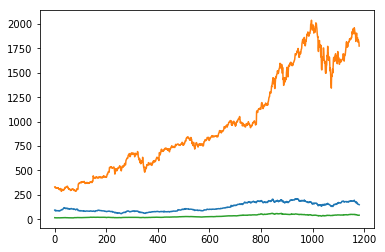

In [344]:
df_close_all = df_all[["AlibabaClose","AmazonClose","TencentClose"]]
plt.plot(df_close_all)

In [348]:
df_close_all

,AlibabaClose,AmazonClose,TencentClose
0,93.889999,331.320007,16.020000
1,89.889999,324.500000,15.400000
2,87.169998,323.630005,15.200000
3,90.570000,328.209991,15.330000
4,88.919998,321.929993,15.010000
5,90.459999,323.209991,15.110000
6,88.750000,321.820007,14.760000
7,88.849998,322.440002,14.820000
8,86.099998,317.459991,14.470000
9,87.059998,318.410004,14.420000
